In [1]:
# Imports
import pandas as pd
import datetime as dt

import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt

import tensorflow as tf
from keras.utils import to_categorical
from tensorflow.keras import layers, models, regularizers, callbacks
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
from imblearn.over_sampling import SMOTE 

In [2]:
def clean_up_observations_and_add_rain_class(atg_obs_selected):
    no_erros_obs = atg_obs_selected.loc[(atg_obs_selected['Rain']!='M')&(atg_obs_selected['Temperature']!='M')&(atg_obs_selected['Pressure']!='M')&(atg_obs_selected['Relhum']!='M')&(atg_obs_selected['Relhum']!='0.00.')].copy()

    no_erros_obs['datetime_PST'] = pd.DatetimeIndex(no_erros_obs['datetime_UTC']).tz_localize('UTC').tz_convert('US/Pacific')
    no_erros_obs['Date_PST'] = pd.DatetimeIndex(no_erros_obs['datetime_PST']).date
    no_erros_obs['Time_PST'] = pd.DatetimeIndex(no_erros_obs['datetime_PST']).time
    no_erros_obs['Rain'] = no_erros_obs['Rain'].astype(float)
    no_erros_obs['Temperature'] = no_erros_obs['Temperature'].astype(float)
    no_erros_obs['Pressure'] = no_erros_obs['Pressure'].astype(float)
    no_erros_obs['Relhum'] = no_erros_obs['Relhum'].astype(float)

    first_obs_each_period = no_erros_obs.resample(on='datetime_UTC', rule='30min')
    summed_rain_each_period = first_obs_each_period['Rain'].sum()

    lightrainfall_times = summed_rain_each_period[(summed_rain_each_period>0.0)]

    summed_rain_each_period.loc[lightrainfall_times.index] = 1

    # Extract Date, Time, Temperature, SumRain into data array
    atg_obs_necessary = pd.DataFrame()
    atg_obs_necessary['date'] = first_obs_each_period['Date_PST'].first()
    atg_obs_necessary['time'] = first_obs_each_period['Time_PST'].first()
    atg_obs_necessary['temperature'] = first_obs_each_period['Temperature'].first()
    atg_obs_necessary['pressure'] = first_obs_each_period['Pressure'].first()
    atg_obs_necessary['relhum'] = first_obs_each_period['Relhum'].first()
    atg_obs_necessary['rainfall_type'] = summed_rain_each_period

    atg_obs_necessary = atg_obs_necessary.dropna()
    data_arr = atg_obs_necessary.values

    return atg_obs_necessary, data_arr

In [3]:
atg_obs = pd.read_csv('../../Downloads/LFEM_data-.csv', low_memory=False, skiprows=1)
atg_obs.insert(0, 'datetime_UTC', pd.to_datetime(atg_obs['Date'] + atg_obs['Time'], format='%Y-%m-%d%H:%M'))

In [4]:
atg_obs_selected = atg_obs.copy() # Selecting dates
atg_obs_selected = atg_obs_selected.loc[(atg_obs['datetime_UTC']>=dt.datetime(2021,5,1))]

In [5]:
# Extract Date, Time, Temperature, SumRain into data array
atg_obs_necessary, data_arr = clean_up_observations_and_add_rain_class(atg_obs_selected)
atg_obs_necessary

,date,time,temperature,pressure,relhum,rainfall_type
datetime_UTC,,,,,,
2021-05-01 00:00:00,2021-04-30,17:00:00,63.6,1016.5,58.8,0.0
2021-05-01 00:30:00,2021-04-30,17:30:00,63.7,1016.2,58.5,0.0
2021-05-01 01:00:00,2021-04-30,18:00:00,64.0,1015.9,56.6,0.0
2021-05-01 01:30:00,2021-04-30,18:30:00,63.8,1015.6,55.0,0.0
2021-05-01 02:00:00,2021-04-30,19:00:00,63.3,1015.5,54.9,0.0
...,...,...,...,...,...,...
2024-05-23 15:30:00,2024-05-23,08:30:00,52.8,1017.1,67.8,0.0
2024-05-23 16:00:00,2024-05-23,09:00:00,53.2,1017.0,66.1,0.0
2024-05-23 16:30:00,2024-05-23,09:30:00,53.2,1017.1,65.3,0.0


In [6]:
def select_times_around_specific_events(atg_obs_necessary, event, num_days_around):
    notable_event_times = atg_obs_necessary.loc[atg_obs_necessary['rainfall_type']>=event].index

    relevant_events = pd.DataFrame()
    for event_time in notable_event_times:
        start_time = event_time-pd.Timedelta(days=num_days_around)
        end_time = event_time+pd.Timedelta(days=num_days_around)
        time_around_event = atg_obs_necessary.loc[start_time:end_time].copy()
        relevant_events = pd.concat([relevant_events, time_around_event]).drop_duplicates()
    
    return relevant_events

In [7]:
relevant_events = select_times_around_specific_events(atg_obs_necessary, 1, 30)
relevant_events

,date,time,temperature,pressure,relhum,rainfall_type
datetime_UTC,,,,,,
2021-05-01 00:00:00,2021-04-30,17:00:00,63.6,1016.5,58.8,0.0
2021-05-01 00:30:00,2021-04-30,17:30:00,63.7,1016.2,58.5,0.0
2021-05-01 01:00:00,2021-04-30,18:00:00,64.0,1015.9,56.6,0.0
2021-05-01 01:30:00,2021-04-30,18:30:00,63.8,1015.6,55.0,0.0
2021-05-01 02:00:00,2021-04-30,19:00:00,63.3,1015.5,54.9,0.0
...,...,...,...,...,...,...
2024-05-23 15:30:00,2024-05-23,08:30:00,52.8,1017.1,67.8,0.0
2024-05-23 16:00:00,2024-05-23,09:00:00,53.2,1017.0,66.1,0.0
2024-05-23 16:30:00,2024-05-23,09:30:00,53.2,1017.1,65.3,0.0


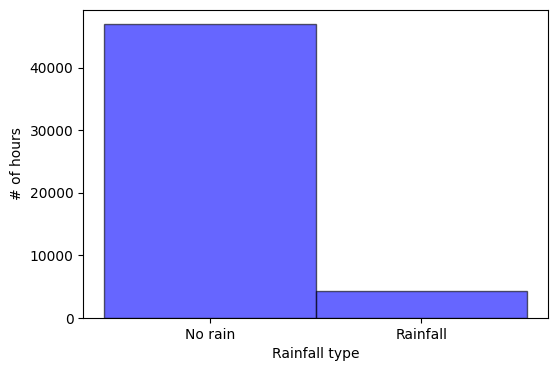

(array([46929,  4289]), array([0., 1., 2.]))

In [8]:
rain_counts, classes = np.histogram(relevant_events['rainfall_type'].values, bins=np.arange(0,relevant_events['rainfall_type'].max()+2))

plt.figure(figsize=(6,4))
plt.bar(x=np.arange(0,relevant_events['rainfall_type'].max()+1), width=1, height=rain_counts, facecolor='blue', edgecolor='k', alpha=0.6)
plt.ylabel('# of hours')
plt.xticks(ticks=np.arange(0,relevant_events['rainfall_type'].max()+1), labels=['No rain', 'Rainfall'])
plt.xlabel('Rainfall type')
plt.show()
rain_counts, classes

In [9]:
def get_processed_df_from_data(dataset):
    date_objs = pd.to_datetime(dataset['date'], format="%Y-%m-%d")
    time_objs = pd.to_datetime(dataset['time'], format='%H:%M:%S')

    months = pd.DatetimeIndex(date_objs).month
    hours = pd.DatetimeIndex(time_objs).hour

    processed_df = pd.DataFrame()
    processed_df['months_from_july'] = months
    # processed_df['time_of_day'] = ((hours-4)%24) / 6

    vals = dataset['temperature']
    processed_df['feature_1'] = vals.values

    vals = dataset['relhum']
    processed_df['feature_2'] = vals.values

    vals = dataset['pressure']
    processed_df['feature_3'] = vals.values

    processed_df['class'] = dataset['rainfall_type'].values
    return processed_df

In [10]:
def create_balanced_df(processed_df):
    ones_samps = processed_df[processed_df['class']==1].copy()
    num_ones = ones_samps.shape[0]

    dupl_processed_df = ones_samps
    group = 0
    under_group_samps = processed_df[processed_df['class']==group].copy()
    group_samps = under_group_samps.sample(n=(num_ones), replace=False, random_state=42)

    dupl_processed_df = pd.concat([dupl_processed_df, group_samps])

    return dupl_processed_df

In [11]:
raw_df_train_val, raw_under_df_test = train_test_split(relevant_events,random_state=42,test_size=0.2)
raw_under_df_train, raw_under_df_val = train_test_split(raw_df_train_val,random_state=42,test_size=0.25)

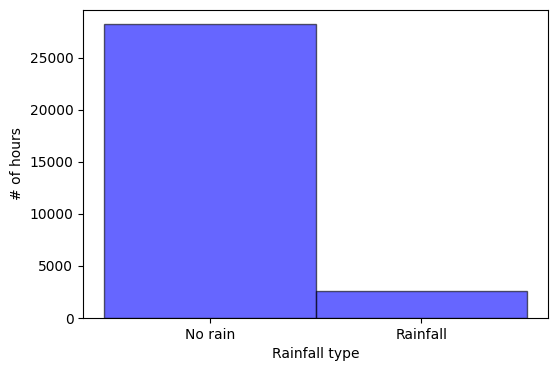

(array([28192,  2538]), array([0., 1., 2.]))

In [12]:
under_sam_reltimes_tr = get_processed_df_from_data(raw_under_df_train)
rain_counts, classes = np.histogram(under_sam_reltimes_tr['class'].values, bins=np.arange(0,under_sam_reltimes_tr['class'].max()+2))

plt.figure(figsize=(6,4))
plt.bar(x=np.arange(0,under_sam_reltimes_tr['class'].max()+1), width=1, height=rain_counts, facecolor='blue', edgecolor='k', alpha=0.6)
plt.ylabel('# of hours')
plt.xticks(ticks=np.arange(0,under_sam_reltimes_tr['class'].max()+1), labels=['No rain', 'Rainfall'])
plt.xlabel('Rainfall type')
plt.show()
rain_counts, classes

In [13]:
processed_df_train = create_balanced_df(under_sam_reltimes_tr)
processed_df_train

,months_from_july,feature_1,feature_2,feature_3,class
2,6,57.1,84.6,1010.2,1.0
8,1,49.0,90.7,1012.5,1.0
11,3,44.1,88.7,1005.9,1.0
18,5,54.7,86.3,1009.5,1.0
39,12,50.6,80.8,993.9,1.0
...,...,...,...,...,...
6038,12,42.0,76.8,991.8,0.0
27725,7,71.3,32.5,1013.6,0.0
10623,11,35.1,79.3,1027.1,0.0
7906,10,46.6,83.7,1018.3,0.0


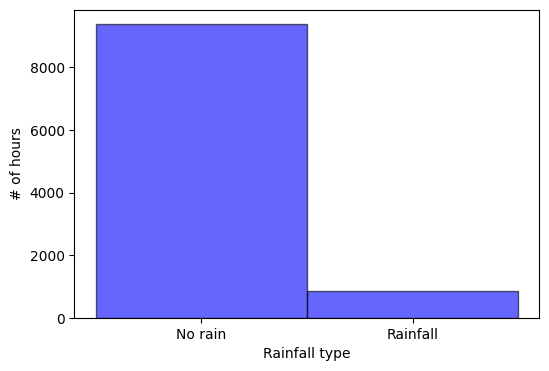

(array([9378,  866]), array([0., 1., 2.]))

In [14]:
processed_df_val = get_processed_df_from_data(raw_under_df_val)
rain_counts, classes = np.histogram(processed_df_val['class'].values, bins=np.arange(0,processed_df_val['class'].max()+2))

plt.figure(figsize=(6,4))
plt.bar(x=np.arange(0,processed_df_val['class'].max()+1), width=1, height=rain_counts, facecolor='blue', edgecolor='k', alpha=0.6)
plt.ylabel('# of hours')
plt.xticks(ticks=np.arange(0,processed_df_val['class'].max()+1), labels=['No rain', 'Rainfall'])
plt.xlabel('Rainfall type')
plt.show()
rain_counts, classes

In [15]:
# processed_df_val = create_balanced_df(under_sam_reltimes_va)
processed_df_val

,months_from_july,feature_1,feature_2,feature_3,class
0,1,43.8,57.7,1020.3,0.0
1,6,56.3,82.5,1009.2,1.0
2,9,65.5,51.1,1010.3,0.0
3,6,65.3,49.5,1023.2,0.0
4,6,50.0,84.2,1014.6,0.0
...,...,...,...,...,...
10239,11,46.9,70.5,1023.7,0.0
10240,12,46.5,85.0,1003.9,1.0
10241,10,53.3,63.1,1014.6,0.0
10242,6,70.3,53.1,1009.1,0.0


In [16]:
processed_df_train.shape, processed_df_val.shape

((5076, 5), (10244, 5))

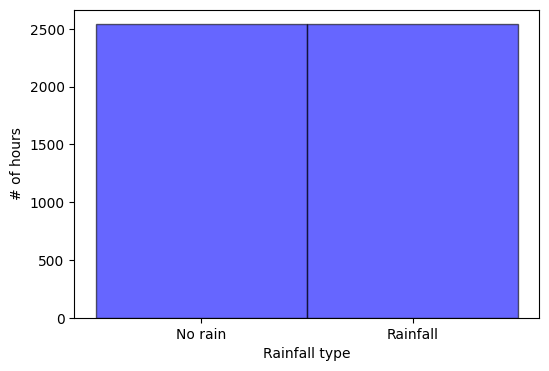

(array([2538, 2538]), array([0., 1., 2.]))

In [17]:
rain_counts, classes = np.histogram(processed_df_train['class'].values, bins=np.arange(0,processed_df_train['class'].max()+2))

plt.figure(figsize=(6,4))
plt.bar(x=np.arange(0,processed_df_train['class'].max()+1), width=1, height=rain_counts, facecolor='blue', edgecolor='k', alpha=0.6)
plt.xticks(ticks=np.arange(0,processed_df_train['class'].max()+1), labels=['No rain', 'Rainfall'])
plt.xlabel('Rainfall type')
plt.ylabel('# of hours')
plt.show()
rain_counts, classes

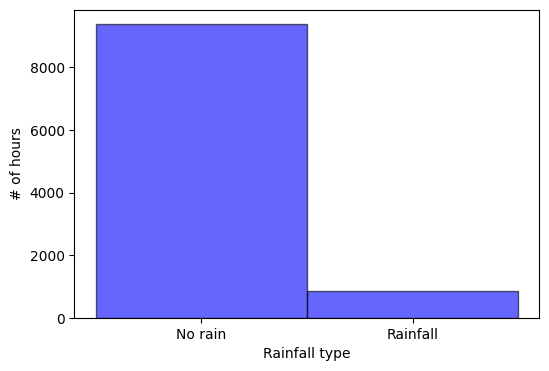

(array([9378,  866]), array([0., 1., 2.]))

In [18]:
rain_counts, classes = np.histogram(processed_df_val['class'].values, bins=np.arange(0,processed_df_train['class'].max()+2))

plt.figure(figsize=(6,4))
plt.bar(x=np.arange(0,processed_df_train['class'].max()+1), width=1, height=rain_counts, facecolor='blue', edgecolor='k', alpha=0.6)
plt.xticks(ticks=np.arange(0,processed_df_train['class'].max()+1), labels=['No rain', 'Rainfall'])
plt.xlabel('Rainfall type')
plt.ylabel('# of hours')
plt.show()
rain_counts, classes

In [19]:
processed_data_train = processed_df_train.values.astype(float)
processed_data_train.shape

(5076, 5)

In [20]:
processed_data_val = processed_df_val.values.astype(float)
processed_data_val.shape

(10244, 5)

In [24]:
x_data_train = processed_data_train[:, :processed_data_train.shape[1]-1]
y_train_labs = processed_data_train[:, processed_data_train.shape[1]-1:]
y_data_train = to_categorical(y_train_labs, int(y_train_labs.max()+1))
print(x_data_train[0], y_data_train[0])

[   6.    57.1   84.6 1010.2] [0. 1.]


In [25]:
x_data_val = processed_data_val[:, :processed_data_val.shape[1]-1]
y_val_labs = processed_data_val[:, processed_data_val.shape[1]-1:]
y_data_val = to_categorical(y_val_labs, int(y_val_labs.max()+1))
print(x_data_val[0], y_data_val[0])

[1.0000e+00 4.3800e+01 5.7700e+01 1.0203e+03] [1. 0.]


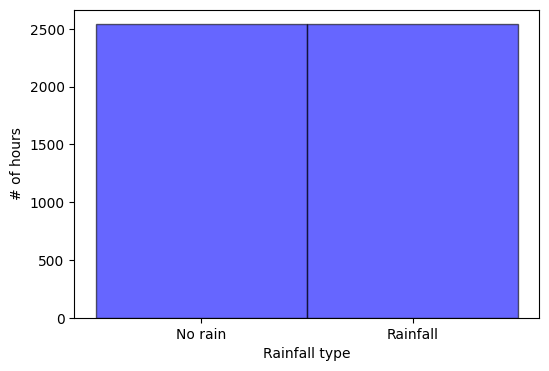

(array([2538, 2538]), array([0., 1., 2.]))

In [26]:
rain_counts, classes = np.histogram(y_train_labs, bins=np.arange(0,y_train_labs.max()+2))

plt.figure(figsize=(6,4))
plt.bar(x=np.arange(0,y_train_labs.max()+1), width=1, height=rain_counts, facecolor='blue', edgecolor='k', alpha=0.6)
plt.ylabel('# of hours')
plt.xticks(ticks=np.arange(0,y_train_labs.max()+1), labels=['No rain', 'Rainfall'])
plt.xlabel('Rainfall type')
plt.show()
rain_counts, classes

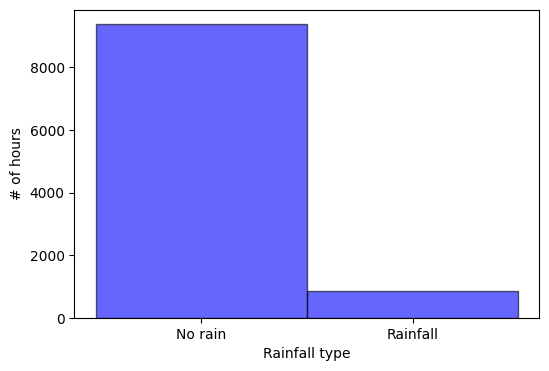

(array([9378,  866]), array([0., 1., 2.]))

In [27]:
rain_counts, classes = np.histogram(y_val_labs, bins=np.arange(0,y_val_labs.max()+2))

plt.figure(figsize=(6,4))
plt.bar(x=np.arange(0,y_val_labs.max()+1), width=1, height=rain_counts, facecolor='blue', edgecolor='k', alpha=0.6)
plt.ylabel('# of hours')
plt.xticks(ticks=np.arange(0,y_val_labs.max()+1), labels=['No rain', 'Rainfall'])
plt.xlabel('Rainfall type')
plt.show()
rain_counts, classes

In [28]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(x_data_train)
X_val_scaled = scaler.transform(x_data_val)

# Define the model
model = models.Sequential()

# Input layer
model.add(layers.Input(shape=(x_data_train.shape[1],)))

# Hidden layers
model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dropout(0.5))

# Output layer
model.add(layers.Dense(int(y_train_labs.max()+1), activation='softmax'))  # Softmax for multiclass classification

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Learning rate reduction callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Early stopping callback
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)

# Print model summary
model.summary()

2024-06-03 11:27:29.347995: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-03 11:27:29.348747: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M2

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               640       
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 2)                 130       
                                             

In [29]:
X_train_scaled.shape, y_data_train.shape

((5076, 4), (5076, 2))

In [30]:
X_val_scaled.shape, y_data_val.shape

((10244, 4), (10244, 2))

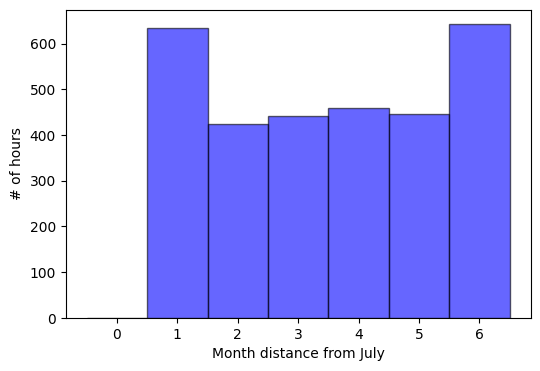

(array([  0, 635, 423, 441, 460, 446, 642]), array([0, 1, 2, 3, 4, 5, 6, 7]))

In [31]:
binwidth = 1
rain_counts, classes = np.histogram(x_data_train[:,0], bins=np.arange(0,7+binwidth,binwidth))

plt.figure(figsize=(6,4))
plt.bar(x=np.arange(0,7,binwidth), width=binwidth, height=rain_counts, facecolor='blue', edgecolor='k', alpha=0.6)
plt.ylabel('# of hours')
plt.xlabel('Month distance from July')
plt.show()
rain_counts, classes

In [32]:
X_train_scaled

array([[-0.0911698 ,  0.54089313,  0.52215674, -0.03395392],
       [-1.40887449, -0.24231878,  0.90513601,  0.24559842],
       [-0.88179261, -0.71611364,  0.77956904, -0.55659525],
       ...,
       [ 1.2265349 , -1.5863491 ,  0.18940427,  2.02014804],
       [ 0.96299396, -0.47438157,  0.46565161,  0.95055649],
       [-0.35471074,  1.33377433, -2.19008984,  0.42791516]])

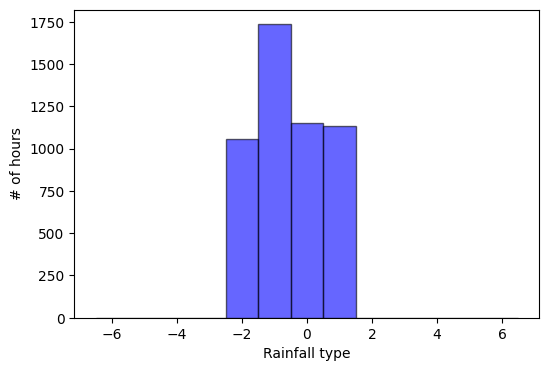

(array([   0,    0,    0,    0, 1058, 1735, 1149, 1134,    0,    0,    0,
           0,    0]),
 array([-6, -5, -4, -3, -2, -1,  0,  1,  2,  3,  4,  5,  6,  7]))

In [33]:
binwidth = 1
rain_counts, classes = np.histogram(X_train_scaled[:,0], bins=np.arange(-6,7+binwidth,binwidth))

plt.figure(figsize=(6,4))
plt.bar(x=np.arange(-6,7,binwidth), width=binwidth, height=rain_counts, facecolor='blue', edgecolor='k', alpha=0.6)
plt.ylabel('# of hours')
plt.xlabel('Rainfall type')
plt.show()
rain_counts, classes

In [34]:
scaler.mean_, scaler.scale_

(array([   6.34594169,   51.50606777,   76.28321513, 1010.47935382]),
 array([ 3.79447689, 10.34202861, 15.92775535,  8.22743968]))

In [35]:
# Train the Model:
history = model.fit(
    X_train_scaled, y_data_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val_scaled, y_data_val),
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/100


2024-06-03 11:27:40.177572: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-06-03 11:27:40.485584: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


159/159 [==============================] - ETA: 0s - loss: 0.7031 - accuracy: 0.7888

2024-06-03 11:27:43.535866: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


159/159 [==============================] - 7s 35ms/step - loss: 0.7031 - accuracy: 0.7888 - val_loss: 0.6008 - val_accuracy: 0.7585 - lr: 0.0010
Epoch 2/100
159/159 [==============================] - 5s 32ms/step - loss: 0.5669 - accuracy: 0.8058 - val_loss: 0.4878 - val_accuracy: 0.7975 - lr: 0.0010
Epoch 3/100
159/159 [==============================] - 5s 32ms/step - loss: 0.5218 - accuracy: 0.8063 - val_loss: 0.4862 - val_accuracy: 0.7765 - lr: 0.0010
Epoch 4/100
159/159 [==============================] - 5s 31ms/step - loss: 0.4954 - accuracy: 0.8075 - val_loss: 0.4496 - val_accuracy: 0.7861 - lr: 0.0010
Epoch 5/100
159/159 [==============================] - 5s 31ms/step - loss: 0.4743 - accuracy: 0.8058 - val_loss: 0.4762 - val_accuracy: 0.7860 - lr: 0.0010
Epoch 6/100
159/159 [==============================] - 5s 31ms/step - loss: 0.4618 - accuracy: 0.8069 - val_loss: 0.3800 - val_accuracy: 0.8201 - lr: 0.0010
Epoch 7/100
159/159 [==============================] - 5s 33ms/step - 

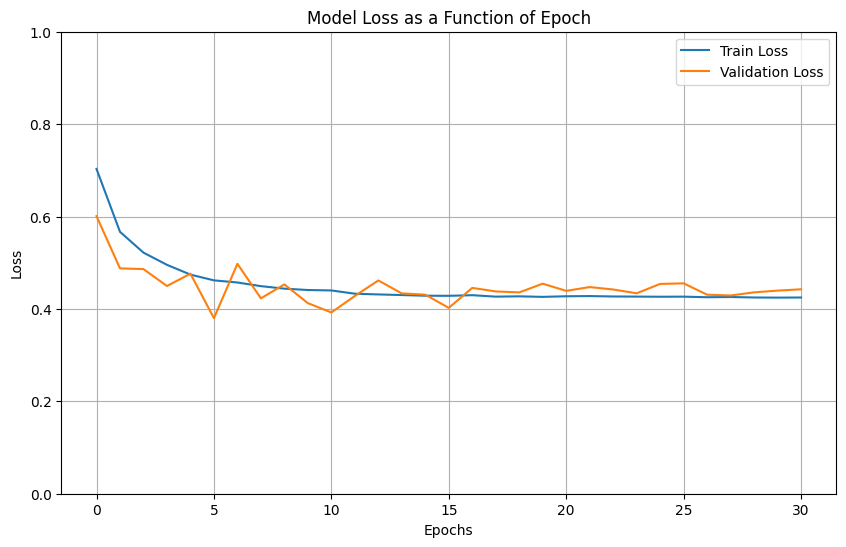

In [36]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the accuracy
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0, 1)
plt.title('Model Loss as a Function of Epoch')
plt.legend()
plt.grid(True)
plt.show()

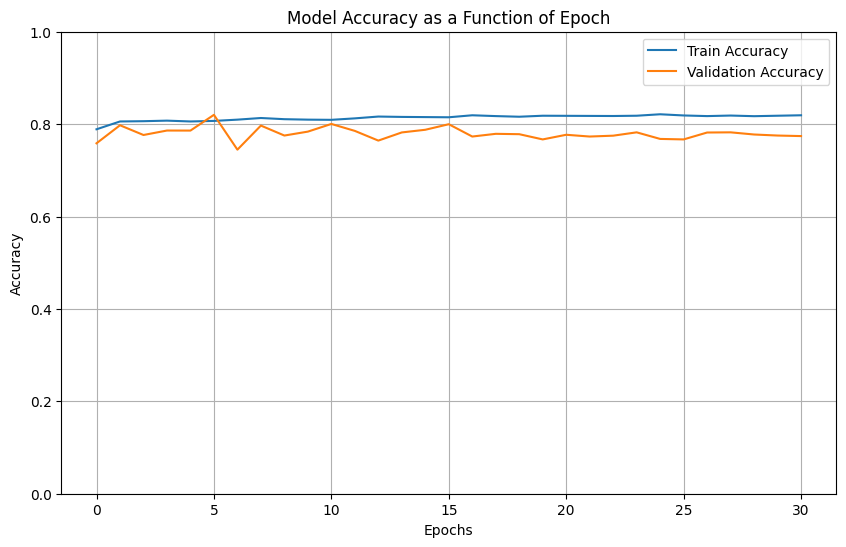

In [37]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plot the accuracy
plt.figure(figsize=(10, 6))
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.title('Model Accuracy as a Function of Epoch')
plt.legend()
plt.grid(True)
plt.show()

In [35]:
# Evaluation (Is it worth, the loss is quite high suggesting that either the model architecture is quite poor (likely) or 
# that we need to better preprocess our data such as rain (also likely))

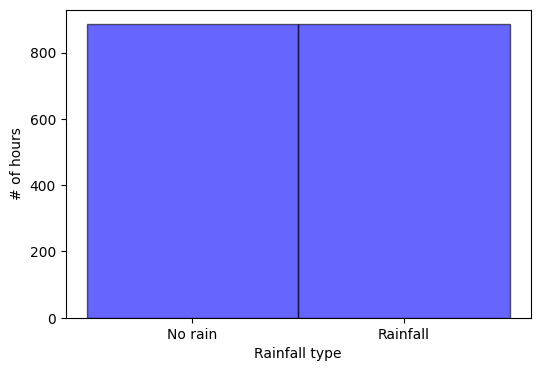

[885 885] [0. 1. 2.]
[   5.    48.    89.9 1018.1] [0. 1.]


In [38]:
under_sam_reltimes_te = get_processed_df_from_data(raw_under_df_test)
processed_df_test = create_balanced_df(under_sam_reltimes_te)

rain_counts, classes = np.histogram(processed_df_test['class'].values, bins=np.arange(0,processed_df_train['class'].max()+2))

plt.figure(figsize=(6,4))
plt.bar(x=np.arange(0,processed_df_train['class'].max()+1), width=1, height=rain_counts, facecolor='blue', edgecolor='k', alpha=0.6)
plt.xticks(ticks=np.arange(0,processed_df_train['class'].max()+1), labels=['No rain', 'Rainfall'])
plt.xlabel('Rainfall type')
plt.ylabel('# of hours')
plt.show()
print(rain_counts, classes)

processed_data_test = processed_df_test.values.astype(float)
x_data_test = processed_data_test[:, :processed_data_test.shape[1]-1]
y_test_labs = processed_data_test[:, processed_data_test.shape[1]-1:]
y_data_test = to_categorical(y_test_labs, int(y_test_labs.max()+1))
print(x_data_test[0], y_data_test[0])

In [39]:
scaler.mean_, scaler.scale_

(array([   6.34594169,   51.50606777,   76.28321513, 1010.47935382]),
 array([ 3.79447689, 10.34202861, 15.92775535,  8.22743968]))

In [40]:
X_test_scaled = scaler.transform(x_data_test)
predictions = model.predict(X_test_scaled)
model.evaluate(X_test_scaled, y_data_test, verbose=2)

47/56 [========================>.....] - ETA: 0s

2024-06-03 11:30:28.986156: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


56/56 [==============================] - 0s 5ms/step
56/56 - 1s - loss: 0.4771 - accuracy: 0.7910 - 612ms/epoch - 11ms/step


[0.4770788252353668, 0.790960431098938]

Confusion Matrix:
[[716 169]
 [201 684]]


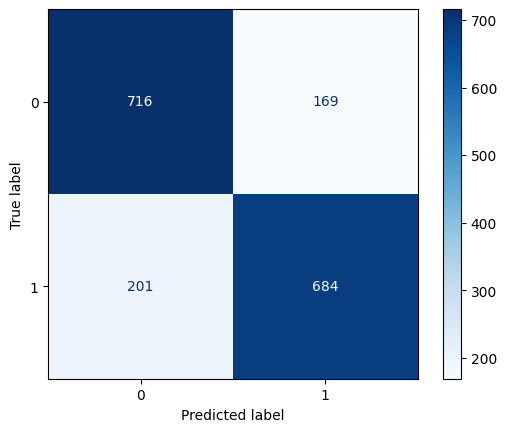

In [41]:
cm = confusion_matrix(np.argmax(y_data_test, axis=1), np.argmax(predictions,axis=1))

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.show()

Confusion Matrix:
[[716 169]
 [201 684]]


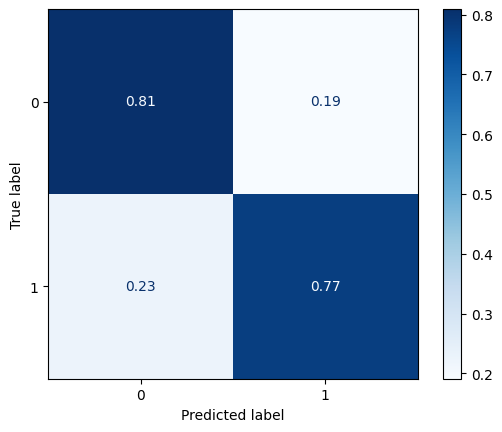

In [42]:
cm = confusion_matrix(np.argmax(y_data_test, axis=1), np.argmax(predictions,axis=1))

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=(cm / np.sum(cm, axis=1).reshape(2, 1)), display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [43]:
f1_score(np.argmax(y_data_test, axis=1), np.argmax(predictions,axis=1), average=None)

array([0.79467259, 0.78711162])

In [44]:
def create_oversampled_df_from_raw(processed_df):
    num_zeros = processed_df[processed_df['rainfall_type']==0].shape[0]

    zeros_samps = processed_df[processed_df['rainfall_type']==0].copy()
    dupl_processed_df = zeros_samps
    for group in np.arange(1, 3):
        under_group_samps = processed_df[processed_df['rainfall_type']==group].copy()
        if len(under_group_samps)>0:
            group_samps = under_group_samps.sample(n=(num_zeros-len(under_group_samps)), replace=True, random_state=42)
            
            np.random.seed(1)
            noise = np.random.normal(0,1,(num_zeros-len(under_group_samps)))
            group_samps['temperature'] = group_samps['temperature']+noise

            np.random.seed(2)
            noise = np.random.normal(0,1,(num_zeros-len(under_group_samps)))
            group_samps['pressure'] = group_samps['pressure']+noise

            np.random.seed(3)
            noise = np.random.normal(0,1,(num_zeros-len(under_group_samps)))
            group_samps['relhum'] = group_samps['relhum']+noise

            dupl_processed_df = pd.concat([dupl_processed_df, under_group_samps, group_samps])

    return dupl_processed_df

In [45]:
raw_under_df_test

,date,time,temperature,pressure,relhum,rainfall_type
datetime_UTC,,,,,,
2023-02-01 13:30:00,2023-02-01,05:30:00,39.5,1017.1,55.3,0.0
2022-09-08 21:30:00,2022-09-08,14:30:00,69.3,1018.5,42.8,0.0
2022-12-03 14:00:00,2022-12-03,06:00:00,38.7,1014.2,79.3,0.0
2022-01-16 04:00:00,2022-01-15,20:00:00,41.8,1023.7,90.6,0.0
2021-12-17 00:00:00,2021-12-16,16:00:00,41.8,1013.1,78.1,0.0
...,...,...,...,...,...,...
2023-10-29 00:30:00,2023-10-28,17:30:00,49.9,1028.5,33.4,0.0
2022-06-10 20:30:00,2022-06-10,13:30:00,65.6,1009.8,66.7,0.0
2022-03-18 07:30:00,2022-03-18,00:30:00,45.7,1016.2,88.2,1.0


In [46]:
import calendar

29/29 [==============================] - 0s 2ms/step


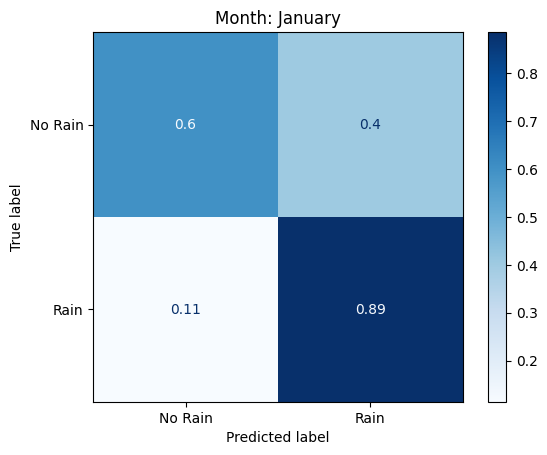

26/26 [==============================] - 0s 3ms/step


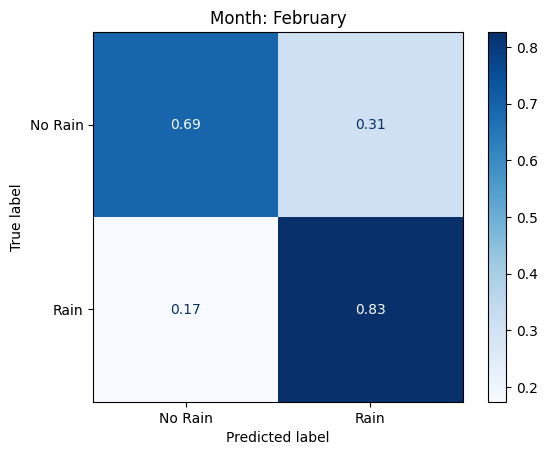

29/29 [==============================] - 0s 3ms/step


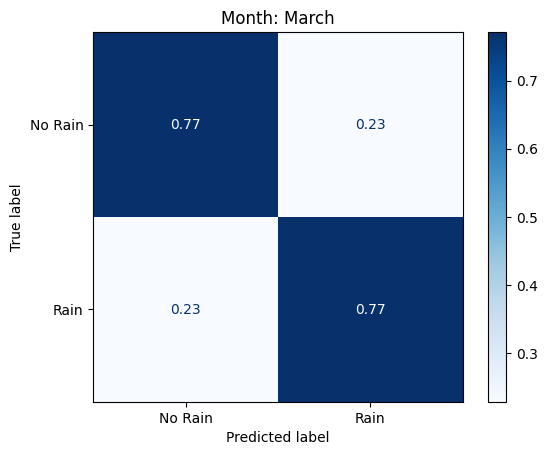

26/26 [==============================] - 0s 3ms/step


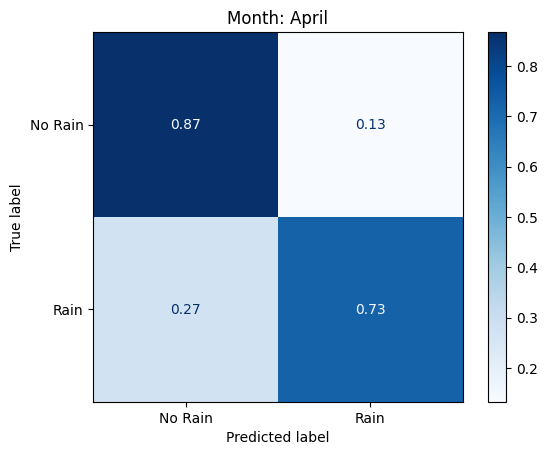

35/35 [==============================] - 0s 2ms/step


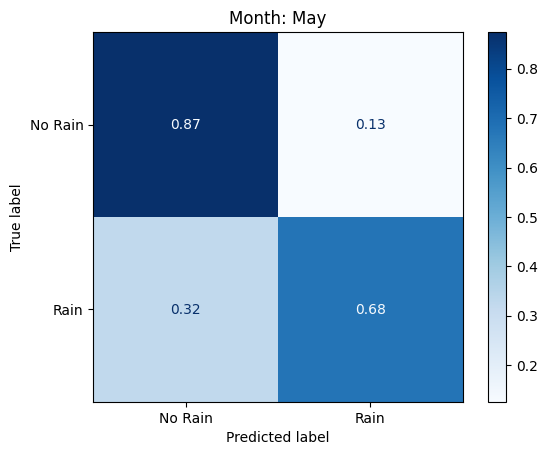

28/28 [==============================] - 0s 3ms/step


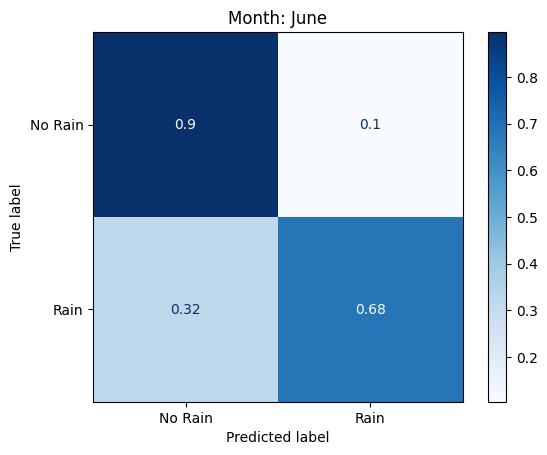

29/29 [==============================] - 0s 2ms/step


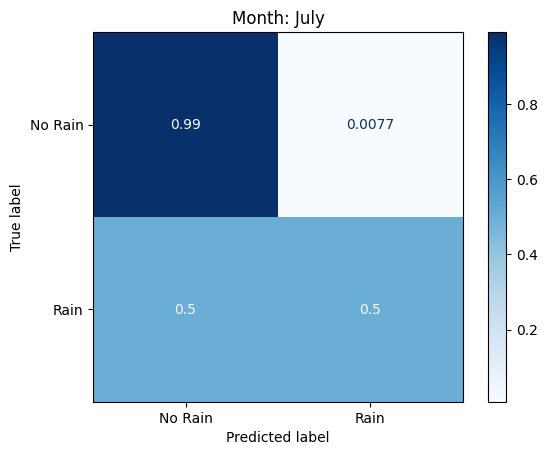

28/28 [==============================] - 0s 3ms/step


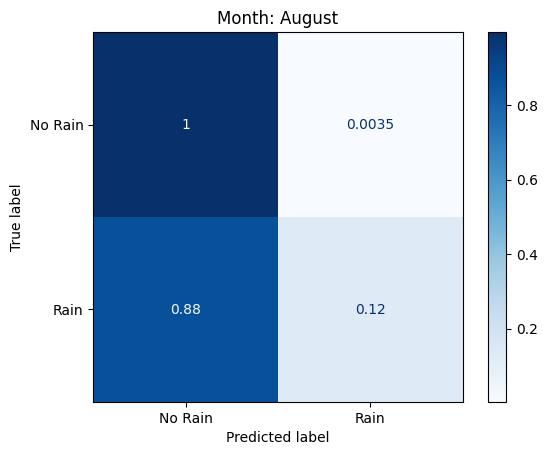

27/27 [==============================] - 0s 5ms/step


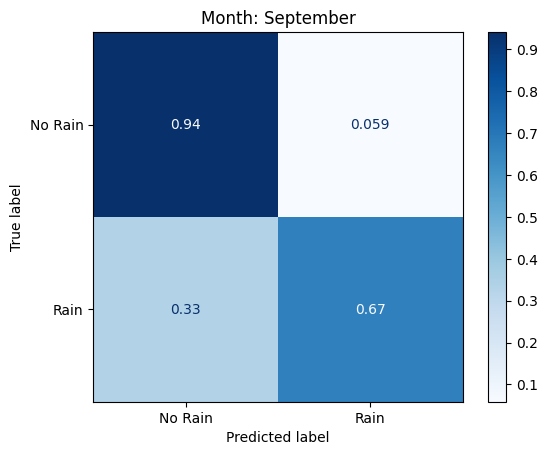

18/18 [==============================] - 0s 3ms/step


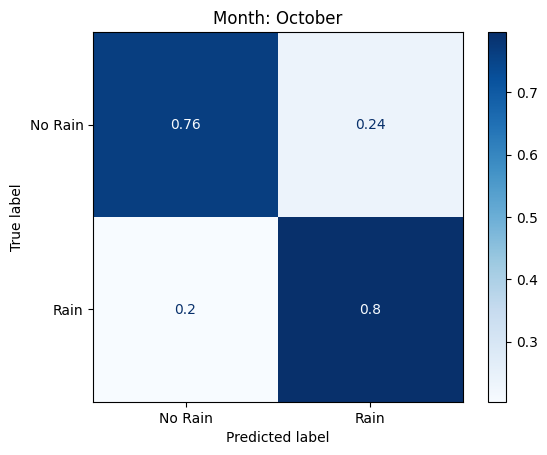

22/22 [==============================] - 0s 3ms/step


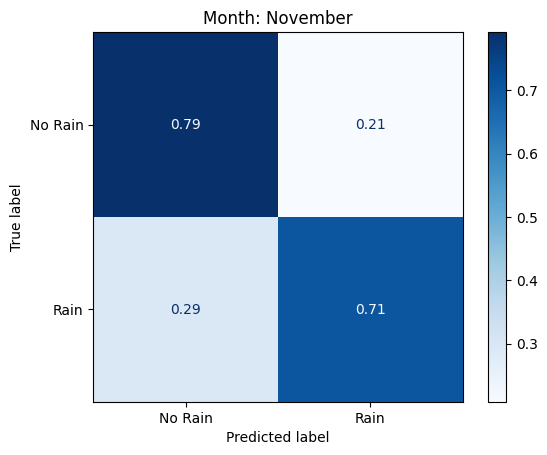

28/28 [==============================] - 0s 2ms/step


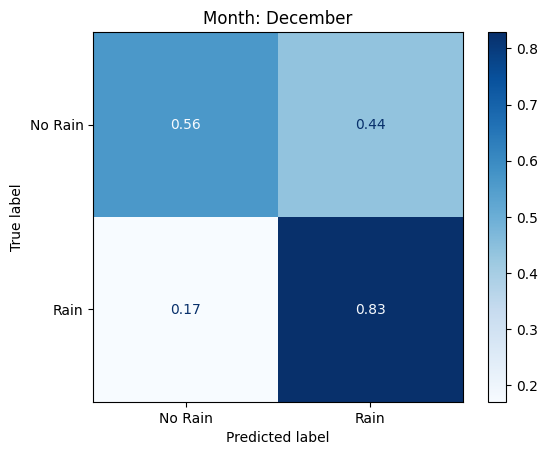

In [48]:
for month_num in np.arange(1, 13):
    test_data_sorted_month = raw_under_df_test.loc[(pd.DatetimeIndex(raw_under_df_test['date']).month==month_num), :].sort_index()
    # processed_test_sorted_month_balanced_raw = create_oversampled_df_from_raw(test_data_sorted_month).sort_index()
    processed_test_sorted_month = get_processed_df_from_data(test_data_sorted_month)
    processed_data_test_month = processed_test_sorted_month.values.astype(float)
    x_data_test_month = processed_data_test_month[:, :processed_data_test_month.shape[1]-1]
    y_test_labs_month = processed_data_test_month[:, processed_data_test_month.shape[1]-1:]
    y_data_test_month = to_categorical(y_test_labs_month, 3)

    X_test_scaled_month = scaler.transform(x_data_test_month)
    predictions_month = model.predict(X_test_scaled_month)

    cm = confusion_matrix(np.argmax(y_data_test_month, axis=1), np.argmax(predictions_month,axis=1))

    # Visualize the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=(cm / np.sum(cm, axis=1).reshape(2, 1)), display_labels=['No Rain', 'Rain'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Month: {calendar.month_name[month_num]}')
    plt.show()